# CNNs with PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = '../Data', train = True, download=True, transform=transform)
test_data = datasets.MNIST(root = '../Data', train = False, download=True, transform=transform)

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [9]:
# 1 COLOR CHANNEL,6 FILTERS (OUTPUT CHANNELS),3by3 KERNEL,STRIDE=1
conv1 = nn.Conv2d(1,6,3,1)

# 6 Input Filters Conv1,16 FILTERS (OUTPUT CHANNELS),3by3 KERNEL,STRIDE=1
conv2 = nn.Conv2d(6,16,3,1)

In [6]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [7]:
X_train.shape

torch.Size([1, 28, 28])

In [10]:
x = X_train.view(1,1,28,28)
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [11]:
x = F.max_pool2d(x, 2,2)

In [12]:
x.shape

torch.Size([1, 6, 13, 13])

In [13]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [14]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [15]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [16]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [24]:
torch.manual_seed(42)
model = ConvolutionNetwork()
model.eval()

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
num_parameters = 0
for param in model.parameters():
    num_parameters += param.numel()

num_parameters

60074

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [26]:
import time
start_time = time.time()

# VARIABLES (TRACKERS)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'EPOCH: {i} BATCH: {b} LOSS: {loss.item()}')

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.numpy())

    # TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.numpy())


current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

EPOCH: 0 BATCH: 600 LOSS: 0.042550548911094666
EPOCH: 0 BATCH: 1200 LOSS: 0.0794178694486618
EPOCH: 0 BATCH: 1800 LOSS: 0.31659600138664246
EPOCH: 0 BATCH: 2400 LOSS: 0.017571672797203064
EPOCH: 0 BATCH: 3000 LOSS: 0.006613238714635372
EPOCH: 0 BATCH: 3600 LOSS: 0.0016816703137010336
EPOCH: 0 BATCH: 4200 LOSS: 0.4892541766166687
EPOCH: 0 BATCH: 4800 LOSS: 0.021441902965307236
EPOCH: 0 BATCH: 5400 LOSS: 0.01042536087334156
EPOCH: 0 BATCH: 6000 LOSS: 0.039831627160310745
EPOCH: 1 BATCH: 600 LOSS: 0.01899746246635914
EPOCH: 1 BATCH: 1200 LOSS: 0.03323657438158989
EPOCH: 1 BATCH: 1800 LOSS: 0.0016125512775033712
EPOCH: 1 BATCH: 2400 LOSS: 0.0629061609506607
EPOCH: 1 BATCH: 3000 LOSS: 0.3251033425331116
EPOCH: 1 BATCH: 3600 LOSS: 0.00015656750474590808
EPOCH: 1 BATCH: 4200 LOSS: 0.0014458318473771214
EPOCH: 1 BATCH: 4800 LOSS: 0.002218470675870776
EPOCH: 1 BATCH: 5400 LOSS: 0.0007657692767679691
EPOCH: 1 BATCH: 6000 LOSS: 0.002254519611597061
EPOCH: 2 BATCH: 600 LOSS: 0.0014027442084625363


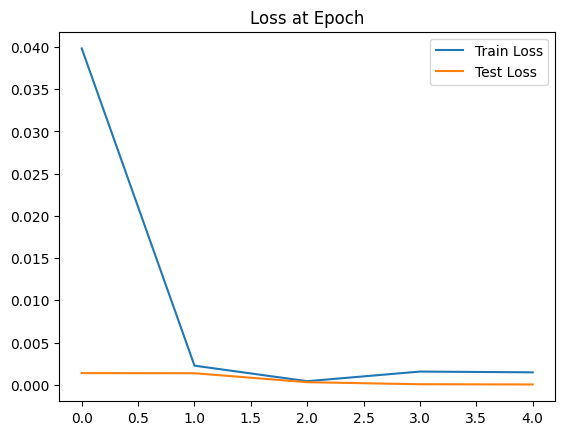

In [28]:
plt.plot(train_losses, label = "Train Loss");
plt.plot(test_losses, label = "Test Loss");
plt.legend();
plt.title('Loss at Epoch');

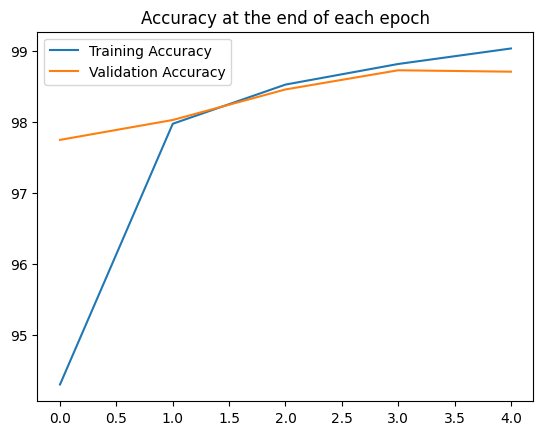

In [29]:
plt.plot([t/600 for t in train_correct], label = "Training Accuracy");
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy");
plt.title("Accuracy at the end of each epoch");
plt.legend();

In [30]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle=False)

In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [32]:
correct.item()/len(test_data)

0.9871

In [33]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    0    0    0    2    3    0    3    0]
 [   0 1131    0    0    0    0    3    6    0    1]
 [   4    0 1019    1    0    0    2    8    2    0]
 [   0    2    7 1009    0   16    0    2    1    1]
 [   0    0    1    0  979    0    1    2    1    9]
 [   0    0    0    0    0  857    4    0    0    3]
 [   1    1    1    0    2    4  944    0    0    1]
 [   1    0    2    0    0    1    0 1004    0    2]
 [   0    1    2    0    0    2    1    1  964    2]
 [   0    0    0    0    1   10    0    5    3  990]]
